Data needed in input: 
- equatorial planes at timepoint 48.5 from epifluorescence timelapse of binary systems in bulk - these can be extracted using the script at "Timelapse Preprocessing - Extraction from ND2/Extraction_equatorial_zplane.ipynb". The script assumes these images are located in a directory termed `experiment_dir`.

In [1]:
# Import dependencies
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Helper function to convert images to 8bit
def convert_8bit(image): 
    return np.array(image, dtype = np.uint8)

In [2]:
# Function to perform Circle Hough Transform
def run_CHT_fluo(
    patch_fluo, 
    blur, 
    param1, 
    param2
): 
    """
    Perform Circle Hough Transform on a fluorescence image patch.

    This function applies a median blur to the input image to reduce noise, 
    then converts the image to color to allow for circle overlays. It uses 
    Circle Hough Transform (OpenCV implementation, with HOUGH_GRADIENT_ALT method)
    to detect circles, and draws the detected circles on the image.

    Parameters:
    patch_fluo (numpy.ndarray): The input grayscale fluorescence image patch.
    blur (int): The kernel size for the median blur operation.
    param1 (float): The higher threshold for the Canny edge detector.
    param2 (float): The measure of circularity required for detected circles.
    
    Returns:
    tuple: A tuple containing:
        - circles (numpy.ndarray): A list of detected circles, each specified by (x, y, radius).
        - cimg (numpy.ndarray): The color image with the detected circles overlaid.
        - If no circles are detected, returns None.
    """
    # Blur (denoising step)
    patch_blur = cv2.medianBlur(patch_fluo, blur)
    # Convert to colour to draw circle overlays
    cimg = cv2.cvtColor(patch_blur,cv2.COLOR_GRAY2BGR)
    # Run actual CHT via more accurate HOUGH_GRADIENT_ALT
    # doc: https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
    circles = cv2.HoughCircles(
        image=patch_blur,
        method=cv2.HOUGH_GRADIENT_ALT,  # method
        dp=5,  # Inverse ratio of the accumulator resolution to the image resolution
        minDist=20,  # Minimum distance between the centers of the detected circles.
        param1=param1,  # higher threshold of the two passed to the Canny edge detector
        param2=param2,  # circle "perfectness" measure
        minRadius=20,  # minimum circle radius
        maxRadius=500  # maximum circle radius
    )
    # Process results from circle segmentation
    if circles is None: 
        return None
    if type(circles.any()) != 'NoneType': 
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            # draw the outer circle
            cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
            cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        return circles, cimg

In [3]:
# Function to run CHT analysis, plot results and return them in a single list
def analyse(images, blur, param1, param2): 
    results = []
    for image in images:
        # Load and convert to 8-bit
        img = cv2.imreadmulti(image)[1][0]
        img_8bit = convert_8bit(img)
        # Plot 8-bit image on the left and circle-overlayed image on the right
        plt.subplots(1, 2, figsize = (8, 4))
        plt.subplot(121)
        plt.imshow(img_8bit)
        plt.subplot(122)
        circles, cimg = run_CHT_fluo(
            img, blur, param1, param2
        )
        plt.imshow(cimg)
        plt.show()
        # Add found circles to growing results list
        results.append(circles)
    return results

In [4]:
def remove_superimposing(circles, min_dist=5, px_um_conv=3.0852): 
    """
    params: 
    circles: list of found circles, each being (x, y, radius)
    min_dist: if distance between X and Y coordinates of two detected circles is lower than min_dist, these
    are considered to be superimposed - only the larger one is kept.
    px_um_conv: pixel to micron for 20x Nikon Ti2 lens in use - change to match your setup
    (in particular, it represents how many pixels equal 1 micron)
    
    returns: 
    list of radii of non-superimposing circles, converted to microns
    """
    xs, ys, rs = [], [], []
    indices = []
    for i in range(len(circles[0])):
        for j in range(i+1, len(circles[0])): 
            if np.abs(float(circles[0][i][0]) - float(circles[0][j][0])) < min_dist: 
                if np.abs(float(circles[0][i][1]) - float(circles[0][j][1])) < min_dist: 
                    if circles[0][i][2] >= circles[0][j][2]: 
                        indices.append(j) # indices to discard
                    elif circles[0][i][2] <= circles[0][j][2]: 
                        indices.append(i) # indices to discard
    print('Excluded indices: ', set(indices))
    for i in range(len(circles[0])): 
        if i not in indices: 
            xs.append(circles[0][i][0])
            ys.append(circles[0][i][1])
            rs.append(circles[0][i][2])
     
    return [circles[0][i][2]*(1/px_um_conv) for i in range(len(circles[0]))  if i not in indices]

In [5]:
# Helper function to process nested list into single flat list.
# This can probably be accomplished with a simple np.concatenate(radii).
def extract_nested_list(radii): 
    radii_list = []
    for i in range(len(radii)): 
        for j in range(len(radii[i])): 
            radii_list.append(radii[i][j])
    return np.array(radii_list)

In [6]:
# CHANGE TO ABSOLUTE PATH OF DIRECTORY CONTAINING IMAGES
experiment_dir = "/ABSOLUTE/PATH/TO/DIRECTORY/"
# CHANGE TO ABSOLUTE PATH OF RESULTS DIRECTORY (WHERE INTERMEDIATE RESULT FILES WILL BE SAVED)
results_dir = "/ABSOLUTE/PATH/TO/RESULTS/DIR/"

In [ ]:
os.chdir(experiment_dir)
files = list(os.listdir())

# Define list of files per sample (one file per FOV and channel)
a1_b4_mg = [file for file in files if 'MG_a1_b4' in file and '._' not in file]
a1_b2_mg = [file for file in files if 'MG_a1_b2' in file and '._' not in file]
a1_b1_mg = [file for file in files if 'MG_a1_b1' in file and '._' not in file]
a2_b1_mg = [file for file in files if 'MG_a2_b1' in file and '._' not in file]
a4_b1_mg = [file for file in files if 'MG_a4_b1' in file and '._' not in file]

a1_b4_dfhbi = [file for file in files if 'DFHBI_a1_b4' in file and '._' not in file]
a1_b2_dfhbi = [file for file in files if 'DFHBI_a1_b2' in file and '._' not in file]
a1_b1_dfhbi = [file for file in files if 'DFHBI_a1_b1' in file and '._' not in file]
a2_b1_dfhbi = [file for file in files if 'DFHBI_a2_b1' in file and '._' not in file]
a4_b1_dfhbi = [file for file in files if 'DFHBI_a4_b1' in file and '._' not in file]

# Analyse

In [ ]:
# [A_T]/[B-T] = 0.25
# Set common params
blur = 3
param2 = 0.5

circles_a1_b4_mg, circles_a1_b4_dfhbi = [
    analyse(images, blur, param1, param2)
    for images, param1 in zip([a1_b4_mg, a1_b4_dfhbi], [50, 60])
]

In [ ]:
# [A_T]/[B-T] = 0.50
# Set common params
blur = 3

circles_a1_b2_mg, circles_a1_b2_dfhbi = [
    analyse(images, blur, param1, param2)
    for images, param1, param2 in zip([a1_b2_mg, a1_b2_dfhbi], [35, 75], [0.5, 0.7])
]

In [ ]:
# [A_T]/[B-T] = 1
# Set common params
blur = 3
param2 = 0.5
 
circles_a1_b1_mg, circles_a1_b1_dfhbi = [
    analyse(images, blur, param1, param2)
    for images, param1 in zip([a1_b1_mg, a1_b1_dfhbi], [45, 70])
]

In [ ]:
# [A_T]/[B-T] = 2
# Set common params
blur = 3
param2 = 0.5
 
circles_a2_b1_mg, circles_a2_b1_dfhbi = [
    analyse(images, blur, param1, param2)
    for images, param1 in zip([a2_b1_mg, a2_b1_dfhbi], [45, 90])
]

In [ ]:
# [A_T]/[B-T] = 4
# Set common params
blur = 3

circles_a4_b1_mg, circles_a4_b1_dfhbi = [
    analyse(images, blur, param1, param2)
    for images, param1, param2 in zip([a4_b1_mg, a4_b1_dfhbi], [33, 120], [0.5, 0.7])
]

# Remove superimposing circles, process and save results

In [ ]:
radii_a1_b4_mg, radii_a1_b4_dfhbi = [
    remove_superimposing(circles) 
    for circles in [circles_a1_b4_mg, circles_a1_b4_dfhbi]
]

radii_a1_b2_mg, radii_a1_b2_dfhbi = [
    remove_superimposing(circles) 
    for circles in [circles_a1_b2_mg, circles_a1_b2_dfhbi]
]

radii_a1_b1_mg, radii_a1_b1_dfhbi = [
    remove_superimposing(circles) 
    for circles in [circles_a1_b1_mg, circles_a1_b1_dfhbi]
]

radii_a2_b1_mg, radii_a2_b1_dfhbi = [
    remove_superimposing(circles) 
    for circles in [circles_a2_b1_mg, circles_a2_b1_dfhbi]
]

radii_a4_b1_mg, radii_a4_b1_dfhbi = [
    remove_superimposing(circles) 
    for circles in [circles_a4_b1_mg, circles_a4_b1_dfhbi]
]

In [ ]:
r = {'A1:B4' : {'MG' : extract_nested_list(radii_a1_b4_mg), 
                 'DFHBI' : extract_nested_list(radii_a1_b4_dfhbi)}, 
    'A1:B2' : {'MG' : extract_nested_list(radii_a1_b2_mg), 
                 'DFHBI' : extract_nested_list(radii_a1_b2_dfhbi)}, 
    'A1:B1' : {'MG' : extract_nested_list(radii_a1_b1_mg), 
                 'DFHBI' : extract_nested_list(radii_a1_b1_dfhbi)},
    'A2:B1' : {'MG' : extract_nested_list(radii_a2_b1_mg), 
                 'DFHBI' : extract_nested_list(radii_a2_b1_dfhbi)}, 
    'A4:B1' : {'MG' : extract_nested_list(radii_a4_b1_mg), 
                 'DFHBI' : extract_nested_list(radii_a4_b1_dfhbi)}}

np.save(results_dir+'radiuses_binary_bulk_CHT.npy', r, allow_pickle=True)

In [7]:
# Reload results to simply plot results once the pipeline has been run
r = np.load(results_dir+'radiuses_binary_bulk_CHT.npy', allow_pickle=True).item()

# Convert in pandas DataFrames and plot

In [8]:
# build single flat list of all radii for A condensates
temp_A = [
    item 
    for key in ['A1:B4', 'A1:B2', 'A1:B1', 'A2:B1', 'A4:B1']
    for item in r[key]['MG']
]
# and matching list of the sample template ratios
temp_ratio_A = sum(
    (len(r[key]['MG']) * [key] for key in ['A1:B4', 'A1:B2', 'A1:B1', 'A2:B1', 'A4:B1']),
    []
)

# same for B condensates
temp_B = [
    item 
    for key in ['A1:B4', 'A1:B2', 'A1:B1', 'A2:B1', 'A4:B1']
    for item in r[key]['DFHBI']
]
temp_ratio_B = sum(
    (len(r[key]['DFHBI']) * [key] for key in ['A1:B4', 'A1:B2', 'A1:B1', 'A2:B1', 'A4:B1']),
    []
)

# Concatenate
data_a = np.array([temp_ratio_A, temp_A])
data_b = np.array([temp_ratio_B, temp_B])

In [9]:
# Convert to pandas DataFrames
dataset_A = pd.DataFrame({'Sample_Template_Ratio': np.array(temp_ratio_A), 'r_A': np.array(temp_A)})
dataset_B = pd.DataFrame({'Sample_Template_Ratio': np.array(temp_ratio_B), 'r_B': np.array(temp_B)})

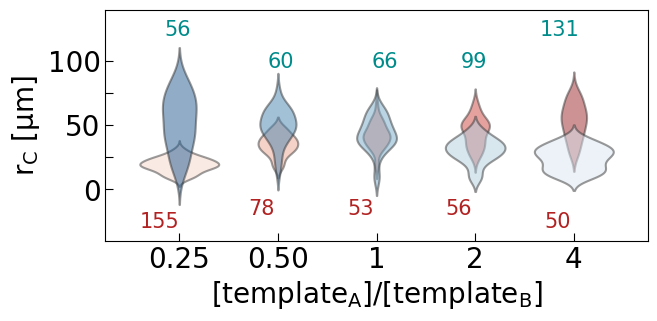

In [10]:
# Plot - Figure 2d
mpl.rcParams['mathtext.default'] = 'regular'

plt.figure(figsize = (7, 3))
ax = sns.violinplot(
    x = 'Sample_Template_Ratio', 
    y = 'r_A', 
    data = dataset_A, 
    palette="Reds", 
    inner = None, 
    scale = 'count', 
    bw = 0.45
)
ax = sns.violinplot(
    x = 'Sample_Template_Ratio', 
    y = 'r_B', 
    data = dataset_B, 
    palette="Blues_r", 
    inner = None, scale = 
    'count', 
    bw = 0.45
)
# X axis
ax.set_xlabel(r'$[template_{A}] / [template_{B}]$', fontsize = 20)
ax.set_xticks([0, 1, 2, 3, 4])
plt.xlim([-0.75, 4.75])
ax.set_xticklabels([0.25, '0.50', 1, 2, 4], fontsize = 20)
# Y axis
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_yticklabels([0, '', 50, '', 100], fontsize = 20)
plt.ylim([-40, 140])
ax.set_ylabel(r'$r_{C}$ [$\mu$m]', fontsize = 20)

ax.tick_params(direction = 'in', length = 6)
plt.setp(ax.collections, alpha=.5);

# Include number of examined condensates for DFHBI channel (B)
plt.text(-0.15, 120, len(r['A1:B4']['DFHBI']), fontsize = 15, color = 'darkcyan')
plt.text(0.90, 95, len(r['A1:B2']['DFHBI']), fontsize = 15, color =  'darkcyan')
plt.text(1.95, 95, len(r['A1:B1']['DFHBI']), fontsize = 15, color =  'darkcyan')
plt.text(2.85, 95, len(r['A2:B1']['DFHBI']), fontsize = 15, color =  'darkcyan')
plt.text(3.65, 120, len(r['A4:B1']['DFHBI']), fontsize = 15, color =  'darkcyan')

# Include number of examined condensates for MG channel (A)
plt.text(-0.40, -30, len(r['A1:B4']['MG']), fontsize = 15, color =  'firebrick')
plt.text(0.7, -20, len(r['A1:B2']['MG']), fontsize = 15, color =  'firebrick')
plt.text(1.7, -20, len(r['A1:B1']['MG']), fontsize = 15, color = 'firebrick')
plt.text(2.7, -20, len(r['A2:B1']['MG']), fontsize = 15, color = 'firebrick')
plt.text(3.7, -30, len(r['A4:B1']['MG']), fontsize = 15, color = 'firebrick')
plt.show()